In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [ ]:
df = pd.read_csv("uncleaned_alzheimers_disease_data.csv")
print("Original Shape:", df.shape)
print("Missing Values:", df.isnull().sum().sum())



Original Shape: (2256, 35)
Missing Values: 7664


In [4]:
# 1. تحديد قائمة الأعمدة التصنيفية
categorical_cols = [
    "Gender", "Ethnicity", "EducationLevel", "Smoking",
    "FamilyHistoryAlzheimers", "CardiovascularDisease",
    "Diabetes", "Depression", "HeadInjury",
    "Hypertension", "MemoryComplaints",
    "BehavioralProblems", "Confusion",
    "Disorientation", "PersonalityChanges",
    "DifficultyCompletingTasks", "Forgetfulness"
]

# 2. حذف الأعمدة غير المهمة مع عدم التكرار
df.drop(['PatientID', 'DoctorInCharge'], axis=1, inplace=True, errors='ignore')

# 3. حذف الصفوف التي ليس بها تشخيص
df.dropna(subset=['Diagnosis'], inplace=True)

# 4. تحديد الأعمدة الرقمية (بقية الأعمدة)
numerical_cols = [col for col in df.columns if col not in categorical_cols + ["Diagnosis"]]

print("تم تنظيف الأعمدة وتحديد الأنواع بنجاح.")

تم تنظيف الأعمدة وتحديد الأنواع بنجاح.


In [5]:
# تعبئة القيم الرقمية بالوسيط (Median)
for col in numerical_cols:
    df[col] = df[col].fillna(df[col].median())

# تعبئة القيم التصنيفية بالمنوال (Mode)
for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0]).astype(int)

# التأكد من أن الهدف (Diagnosis) نوعه رقمي صحيح
df["Diagnosis"] = df["Diagnosis"].astype(int)

print("Cleaned Shape:", df.shape)
print("Missing Values:", df.isnull().sum().sum())

Cleaned Shape: (2029, 33)
Missing Values: 0


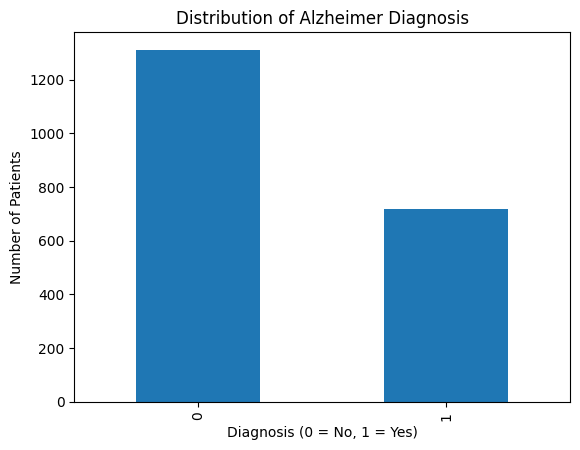

In [7]:
plt.figure()
df["Diagnosis"].value_counts().plot(kind="bar")
plt.title("Distribution of Alzheimer Diagnosis")
plt.xlabel("Diagnosis (0 = No, 1 = Yes)")
plt.ylabel("Number of Patients")
plt.show()


<Figure size 640x480 with 0 Axes>

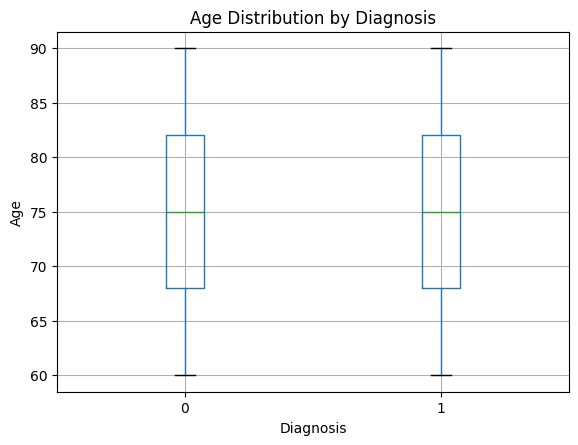

In [8]:
plt.figure()
df.boxplot(column="Age", by="Diagnosis")
plt.title("Age Distribution by Diagnosis")
plt.suptitle("")
plt.xlabel("Diagnosis")
plt.ylabel("Age")
plt.show()


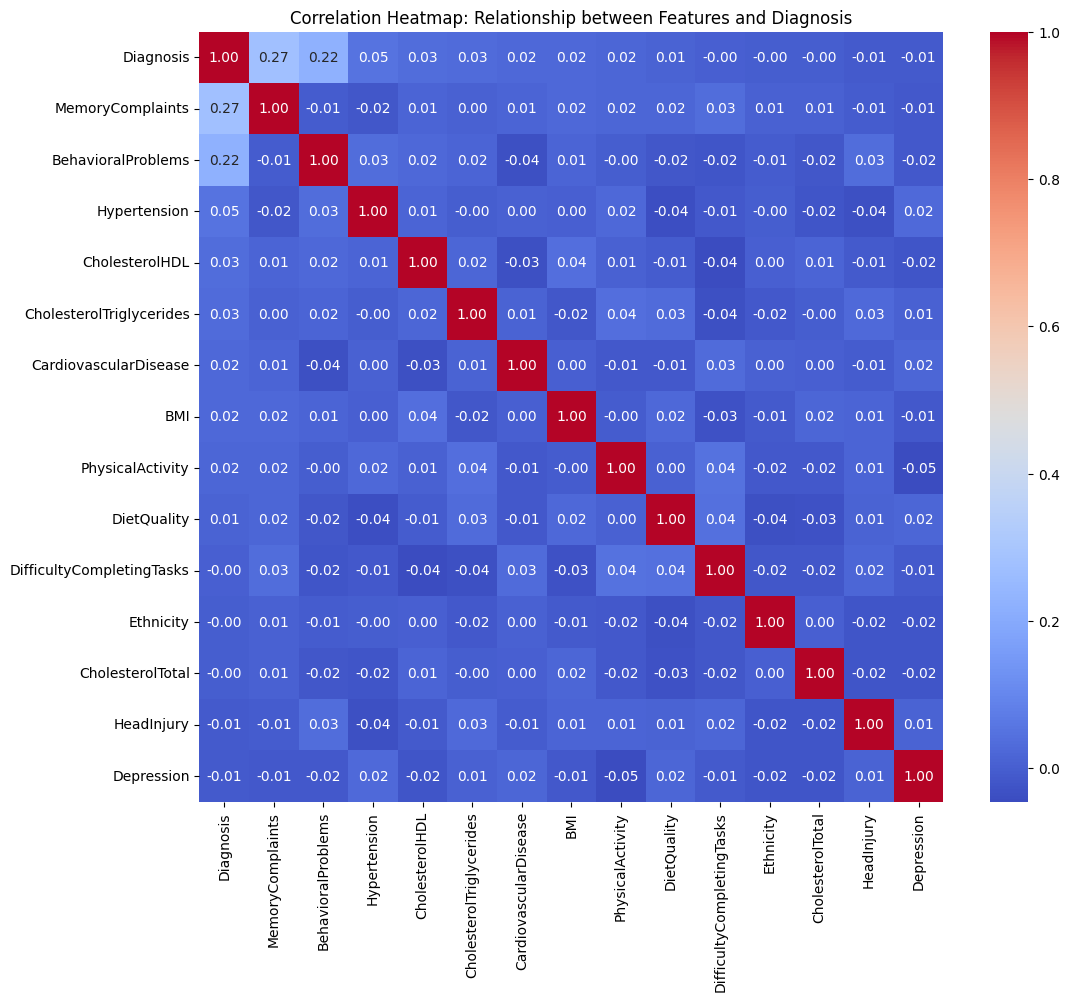

In [9]:
# رسم خريطة الحرارة للارتباط بين المتغيرات
plt.figure(figsize=(12, 10))
# اخترنا أهم 15 متغير عشان الرسمة تكون واضحة
top_corr_features = df.corr()['Diagnosis'].sort_values(ascending=False).head(15).index
sns.heatmap(df[top_corr_features].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap: Relationship between Features and Diagnosis")
plt.show()


In [10]:
# فصل الميزات عن الهدف
X = df.drop("Diagnosis", axis=1)
y = df["Diagnosis"]

# تقسيم البيانات (80% تدريب، 20% اختبار)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# توحيد مقاييس البيانات (Scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("تم تقسيم البيانات وعمل Scaling بنجاح.")

تم تقسيم البيانات وعمل Scaling بنجاح.


In [11]:
# 1. إنشاء وتدريب موديل Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_scaled, y_train)

# 2. التنبؤ بالنتائج
y_pred_lr = lr.predict(X_test_scaled)

# 3. طباعة النتائج
print("--- Logistic Regression Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nClassification Report:\n", classification_report(y_test, y_pred_lr))

--- Logistic Regression Evaluation ---
Accuracy: 0.8374384236453202

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.91      0.88       262
           1       0.81      0.70      0.75       144

    accuracy                           0.84       406
   macro avg       0.83      0.81      0.82       406
weighted avg       0.84      0.84      0.83       406



In [12]:
# 1. إنشاء وتدريب موديل Random Forest
rf = RandomForestClassifier(n_estimators=200, random_state=42)
rf.fit(X_train_scaled, y_train)

# 2. التنبؤ بالنتائج
y_pred_rf = rf.predict(X_test_scaled)

# 3. طباعة النتائج
print("--- Random Forest Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nClassification Report:\n", classification_report(y_test, y_pred_rf))

--- Random Forest Evaluation ---
Accuracy: 0.8940886699507389

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.95      0.92       262
           1       0.89      0.80      0.84       144

    accuracy                           0.89       406
   macro avg       0.89      0.87      0.88       406
weighted avg       0.89      0.89      0.89       406



C:\Users\Khaled\AppData\Local\Temp\ipykernel_25984\1171167960.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')


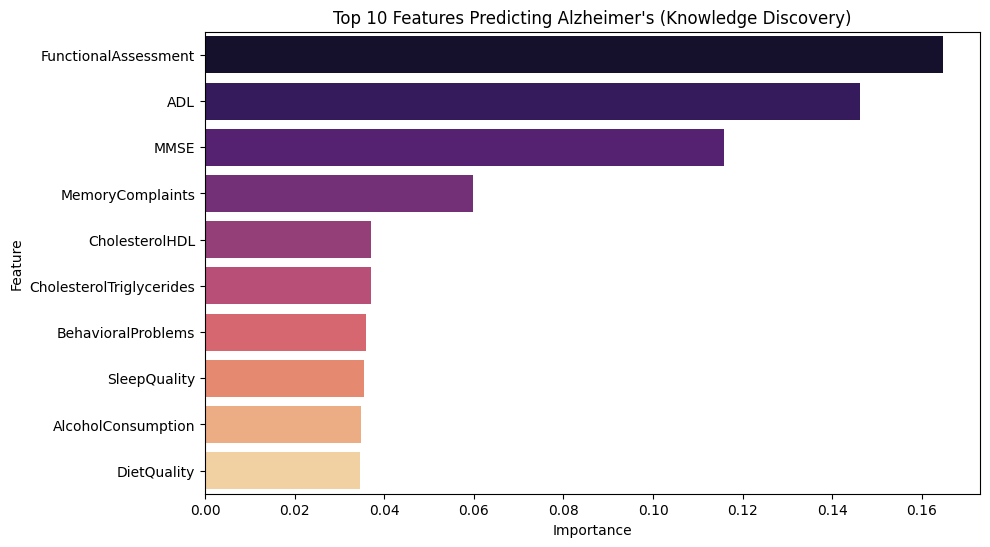

In [19]:
# استخراج أهمية كل ميزة من موديل Random Forest
importances = rf.fit(X_train_scaled, y_train).feature_importances_
feature_names = X.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False).head(10)

# رسم أهم 10 ميزات
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df, palette='magma')
plt.title("Top 10 Features Predicting Alzheimer's (Knowledge Discovery)")
plt.show()

--- Manual Performance Metrics (Lecture 5 - Slide 40) ---
True Positives (TP): 115
True Negatives (TN): 248
False Positives (FP): 14
False Negatives (FN): 29

Manual Accuracy: 0.8941


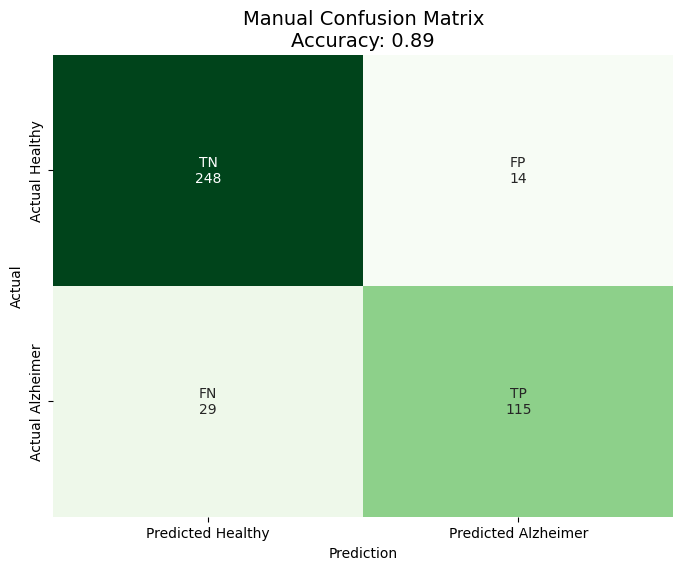

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# 1. حساب القيم يدوياً
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_rf).ravel()
manual_accuracy = (tp + tn) / (tp + tn + fp + fn)

# 2. طباعة النتائج النصية 
print("--- Manual Performance Metrics (Lecture 5 - Slide 40) ---")
print(f"True Positives (TP): {tp}")
print(f"True Negatives (TN): {tn}")
print(f"False Positives (FP): {fp}")
print(f"False Negatives (FN): {fn}")
print(f"\nManual Accuracy: {manual_accuracy:.4f}")

# 3. رسم المصفوفة مع المسميات العلمية 
cm_data = [[tn, fp], [fn, tp]]
labels = [[f'TN\n{tn}', f'FP\n{fp}'], [f'FN\n{fn}', f'TP\n{tp}']]

plt.figure(figsize=(8, 6))
sns.heatmap(cm_data, annot=labels, fmt="", cmap='Greens', cbar=False,
            xticklabels=['Predicted Healthy', 'Predicted Alzheimer'],
            yticklabels=['Actual Healthy', 'Actual Alzheimer'])

plt.title(f'Manual Confusion Matrix\nAccuracy: {manual_accuracy:.2f}', fontsize=14)
plt.xlabel('Prediction')
plt.ylabel('Actual')
plt.show()

In [15]:
from sklearn.tree import DecisionTreeClassifier

# 1. إنشاء وتدريب الموديل
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_scaled, y_train)

# 2. التنبؤ
y_pred_dt = dt.predict(X_test_scaled)

# 3. النتائج
print("--- Decision Tree Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))

--- Decision Tree Evaluation ---
Accuracy: 0.8694581280788177

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.88      0.90       262
           1       0.79      0.85      0.82       144

    accuracy                           0.87       406
   macro avg       0.85      0.87      0.86       406
weighted avg       0.87      0.87      0.87       406



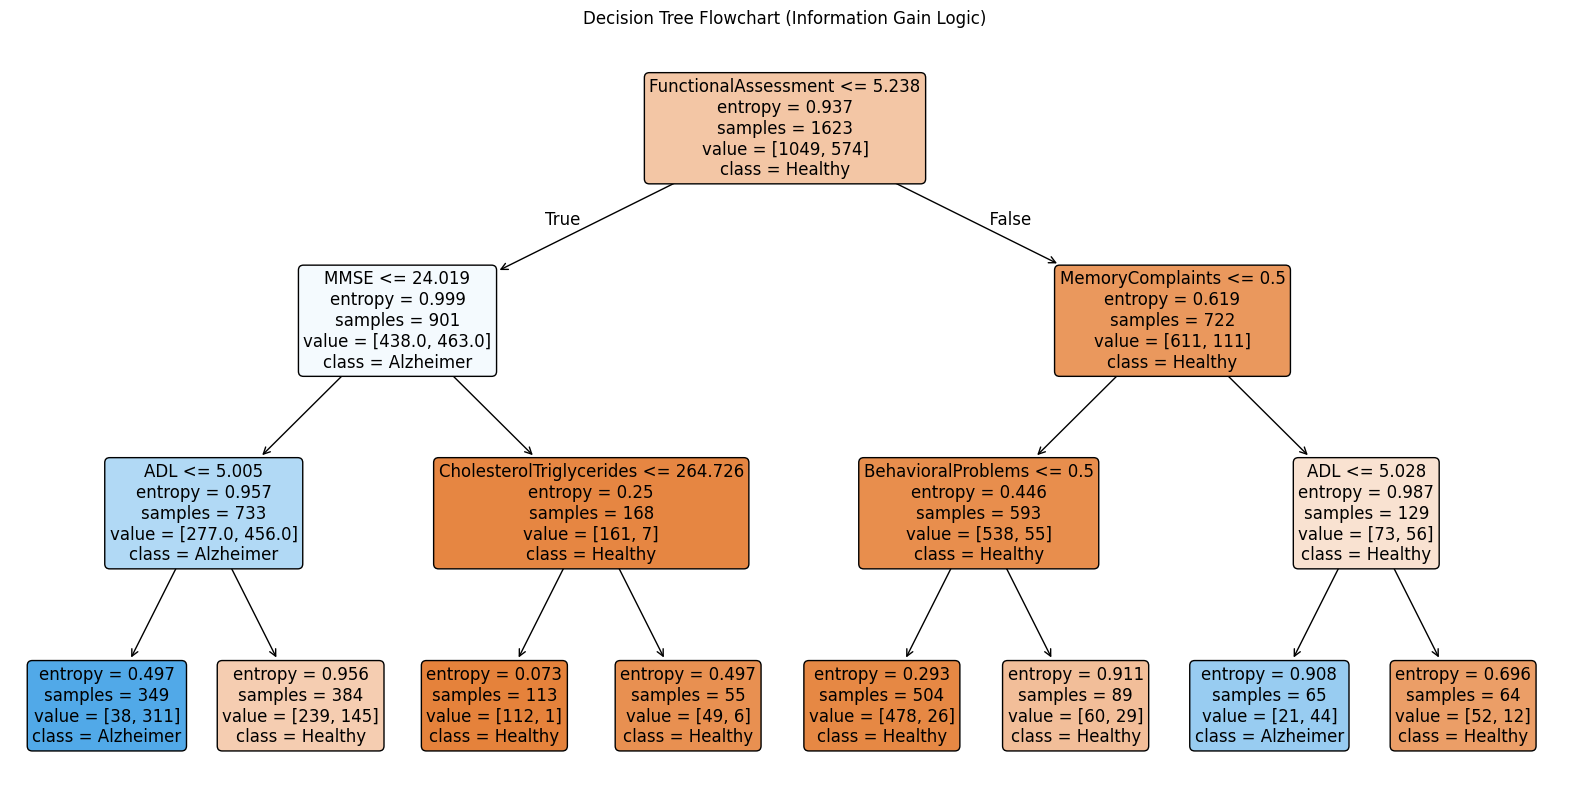

In [16]:
from sklearn.tree import plot_tree

# سنرسم شجرة بسيطة (عمق 3) عشان تكون واضحة في العرض
dt_plot = DecisionTreeClassifier(max_depth=3, criterion='entropy')
dt_plot.fit(X_train, y_train)

plt.figure(figsize=(20, 10))
plot_tree(dt_plot, feature_names=X.columns, class_names=['Healthy', 'Alzheimer'], 
          filled=True, rounded=True, fontsize=12)
plt.title("Decision Tree Flowchart (Information Gain Logic)")
plt.show()

In [17]:
from sklearn.naive_bayes import GaussianNB

# 1. إنشاء وتدريب الموديل
nb = GaussianNB()
nb.fit(X_train_scaled, y_train)

# 2. التنبؤ
y_pred_nb = nb.predict(X_test_scaled)

# 3. النتائج
print("--- Naïve Bayes Evaluation ---")
print("Accuracy:", accuracy_score(y_test, y_pred_nb))
print("\nClassification Report:\n", classification_report(y_test, y_pred_nb))

--- Naïve Bayes Evaluation ---
Accuracy: 0.8029556650246306

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.88      0.85       262
           1       0.75      0.67      0.71       144

    accuracy                           0.80       406
   macro avg       0.79      0.77      0.78       406
weighted avg       0.80      0.80      0.80       406



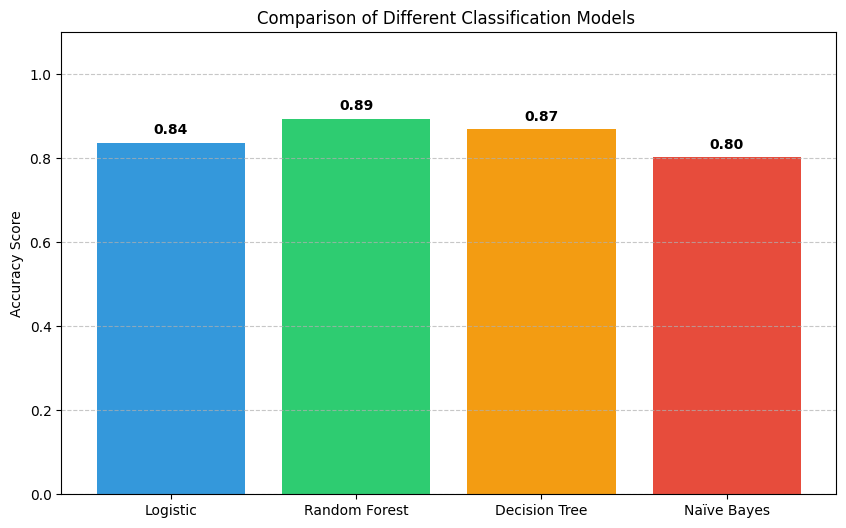

In [18]:
import matplotlib.pyplot as plt

# 1. تجميع نتائج الأدق لكل موديل
models = ['Logistic', 'Random Forest', 'Decision Tree', 'Naïve Bayes']
accuracies = [
    accuracy_score(y_test, y_pred_lr),
    accuracy_score(y_test, y_pred_rf),
    accuracy_score(y_test, y_pred_dt),
    accuracy_score(y_test, y_pred_nb)
]

# 2. رسم المقارنة
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['#3498db', '#2ecc71', '#f39c12', '#e74c3c'])

# 3. تحسين شكل الرسم
plt.ylim(0, 1.1) # جعل المدى يصل لـ 1.1 لترك مساحة للأرقام فوق الأعمدة
plt.ylabel('Accuracy Score')
plt.title('Comparison of Different Classification Models ')

# 4. إضافة الأرقام فوق كل عمود (تم تصحيح الجزء المسبب للخطأ هنا)
for i, v in enumerate(accuracies):
    plt.text(i, v + 0.02, f"{v:.2f}", ha='center', fontweight='bold')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()